In [1]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

from PySpice.Spice.Netlist import Circuit

import schemdraw
import schemdraw.elements as elm

Чисто для справки -- схема лестничного фильтра 7-го порядка:

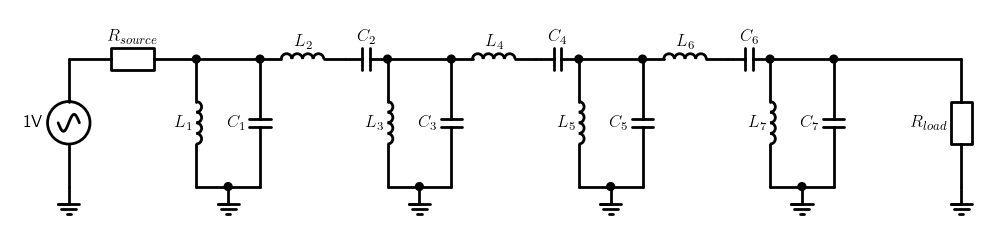

In [2]:
d = schemdraw.Drawing()
gnd = d.add(elm.Ground())
d.add(elm.SourceSin(d='up', label='1V'))
d.add(elm.RBox(d='right', label='$R_{source}$'))

for i in range(1, 8, 2):
    d.add(elm.Dot())
    l1 = d.add(elm.Inductor(d='down', label=f'$L_{i}$'))
    line1 = d.add(elm.Line(d = 'r', l=1.5, at = l1.start))
    c1 = d.add(elm.Capacitor(d='down', label=f'$C_{i}$'))
    line1i = d.add(elm.Line(endpts = [l1.end, c1.end]))
    d.add(elm.Ground(at = line1i.center))
    d.add(elm.Dot())
    d.add(elm.Dot(at = c1.start))

    if (i != 7):
        l2 = d.add(elm.Inductor(l=2.0, d='right', label=f'$L_{i+1}$'))
        c2 = d.add(elm.Capacitor(l=1.0, d='right', label=f'$C_{i+1}$'))
    else:
        d.add(elm.Line(d = 'r'))
        d.add(elm.RBox(d = 'd', label = '$R_{load}$'))
        d.add(elm.Ground())


d.draw()

Параметры обозначены так же, как и в методичке:

In [3]:
f0 = 465e3            # центральная частота
R0 = 600              # выходное сопротивление источника
Q = 19.375            # Q-фактор = f0/ df

L0 = R0/(2*np.pi*f0)
C0 = 1/(2*np.pi*f0*R0)

# Коэффициенты лестничных фильтров
gs = {
    "butter":   [1.0, 0.445, 1.247, 1.802, 2.0,   1.802, 1.247, 0.445, 1.0],
    "cheb05db": [1.0, 1.737, 1.258, 2.638, 1.344, 2.638, 1.258, 1.737, 1.0],
    "cheb3db":  [1.0, 3.518, 0.772, 4.639, 0.804, 4.639, 0.772, 3.518, 1.0]
}
names = gs.keys()

Рисуем одинаковые лестничные схемы 7-го порядка и запускаем на них AC-симуляцию. Результаты складываем в словарь results

In [4]:
results = {}
for name in names:
    g = gs[name]
    circuit = Circuit(name)
    
    circuit.SinusoidalVoltageSource(0, 'n0', circuit.gnd, amplitude=1)

    Rs = circuit.R('s', 'n0', 'n1', R0*g[0])
    Rl = circuit.R('l', 'n7', circuit.gnd, R0/g[0])

    for i in range(1, 8, 2):
        circuit.C(i, f'n{i}', circuit.gnd, C0*(g[i]*Q))
        circuit.L(i, f'n{i}', circuit.gnd, L0/(g[i]*Q))
    for i in range(2, 8, 2):
        circuit.L(i, f'n{i-1}', f'n{i}', L0*(g[i]*Q))
        circuit.C(i, f'n{i}', f'n{i+1}', C0/(g[i]*Q))

    simulator = circuit.simulator()
    analysis = simulator.ac(start_frequency=f0*(1-2/Q), stop_frequency=f0*(1+2/Q), number_of_points=1000,  variation='lin')
    r = {
        "f" : analysis.frequency,
        "H" : 20*np.log10(np.abs(analysis.n7)),
        "ph" : np.unwrap(np.angle(analysis.n7))
    }
    results[name] = r

Unsupported Ngspice version 36
Should be unit less
Should be unit less
Should be unit less
Should be unit less
Should be unit less
Should be unit less


Графики для выходной мощности (корректируем на коэффициент 6 дБ из-за потерь на 0-м резисторе)

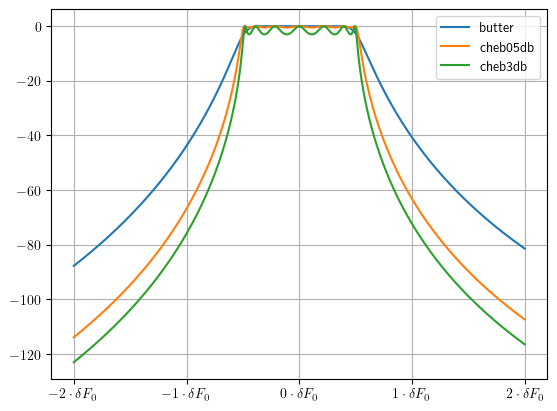

In [5]:
for name in names:  
    plt.plot(results[name]["f"], 6.0 + results[name]["H"], label = name)    
plt.xticks(f0*(1+np.arange(-2, 3)/Q), [f"${a} \cdot \delta F_0$" for a in np.arange(-2, 3)])
plt.grid(True)
plt.legend()

Ну, и значения селективности на соседнем канале (том, что слева, и на том, что справа)

In [6]:
for name in names:
    low, mid, high = tuple(interp1d(results[name]['f'], results[name]['H'])([f0*(1-1/Q), f0, f0*(1+1/Q)]))
    low = low - mid
    high = high - mid
    print(f"Selectivity for {name:10s}: LF edge = {low:4.2f} dB, HF edge = {high:4.2f} dB")

Selectivity for butter    : LF edge = -43.78 dB, HF edge = -40.63 dB
Selectivity for cheb05db  : LF edge = -66.78 dB, HF edge = -63.15 dB
Selectivity for cheb3db   : LF edge = -75.90 dB, HF edge = -72.27 dB
